In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, ISN_coeff
#from epi.SSSN import SSSN_sim_tfp
from epi.SSSN import load_SSSN_variable
from epi.util import plot_T_x


neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "/Users/seanbittner/Documents/epi/written/V1_model/figs/FigSX/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
"""from scipy.io import loadmat 
import os
matfile = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))
maxE = matfile['maxE']
#plt.figure()
#plt.hist(np.real(maxE[:,0]))
#lt.show()

#plt.figure()
#plt.hist(np.real(maxE[:,-1]))
#plt.show()

inds = np.argsort(maxE[:,-1])
print('inds', inds[:10])
print(maxE[inds[0]])
"""

'from scipy.io import loadmat \nimport os\nmatfile = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))\nmaxE = matfile[\'maxE\']\n#plt.figure()\n#plt.hist(np.real(maxE[:,0]))\n#lt.show()\n\n#plt.figure()\n#plt.hist(np.real(maxE[:,-1]))\n#plt.show()\n\ninds = np.argsort(maxE[:,-1])\nprint(\'inds\', inds[:10])\nprint(maxE[inds[0]])\n'

In [7]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [8]:
ind = 1070
HB = load_SSSN_variable('hb', ind=ind)
HC = load_SSSN_variable('hc', ind=ind)
W = load_SSSN_variable('W', ind=ind)
print('hb', HB)
print('hc', HC)
print('W', W)

lb = -0.25*np.ones((4,))
ub = 0.25*np.ones((4,))
dh = Parameter("dh", 4, lb=lb, ub=ub)
parameters = [dh]

# Define model
name = "SSSN"
model = Model(name, parameters)


hb tf.Tensor([0.590407   0.50438005 0.5148208  0.6697344 ], shape=(4,), dtype=float32)
hc tf.Tensor([0.594786 0.396027 0.       0.      ], shape=(4,), dtype=float32)
W tf.Tensor(
[[ 7.8499717e-01 -1.0167271e-01 -1.2381849e+00 -3.0604100e-01]
 [ 8.0936223e-01 -1.0012230e-01 -6.2031293e-01 -2.6355028e-01]
 [ 8.3325022e-01 -1.2843312e-04 -4.8323123e-05 -7.4179840e-01]
 [ 7.0760316e-01 -3.0636516e-01 -4.5228127e-01 -6.0519189e-05]], shape=(4, 4), dtype=float32)


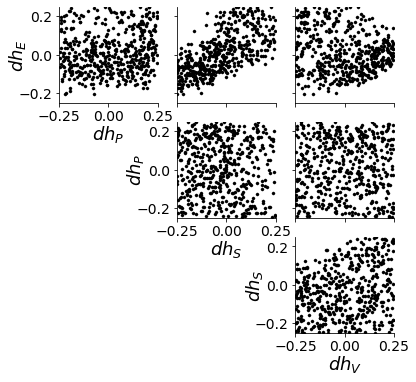

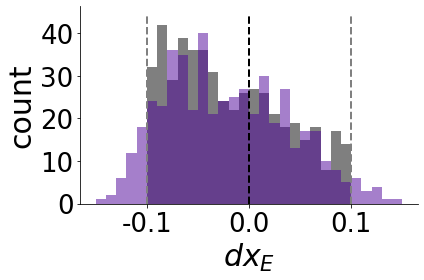

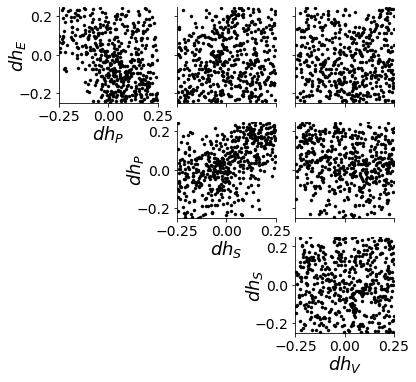

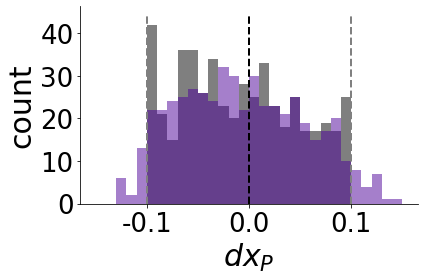

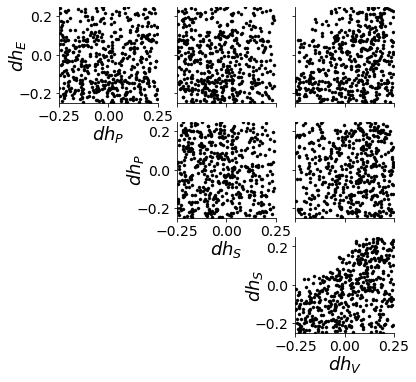

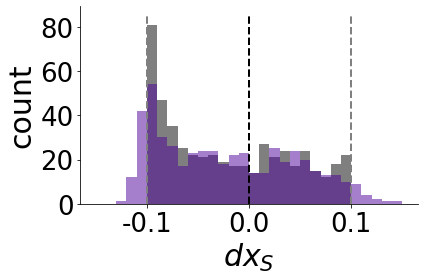

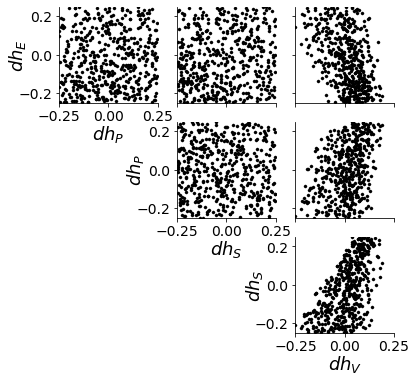

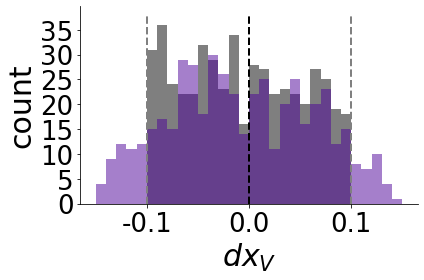

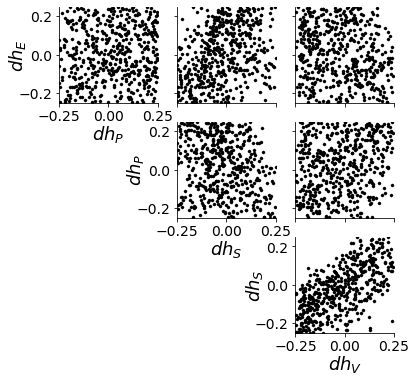

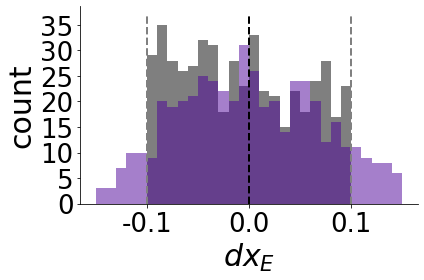

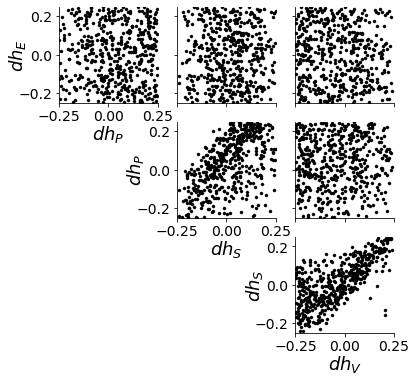

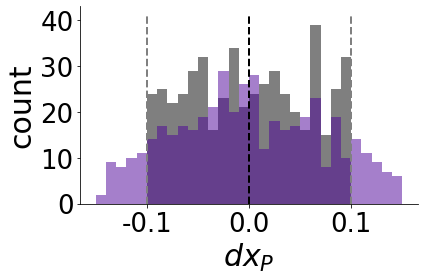

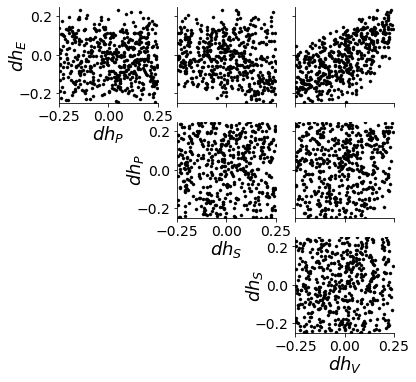

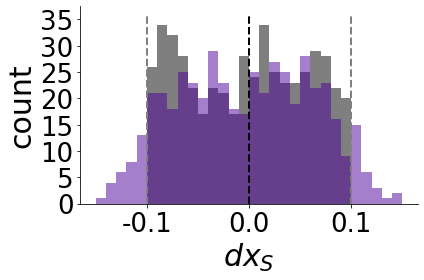

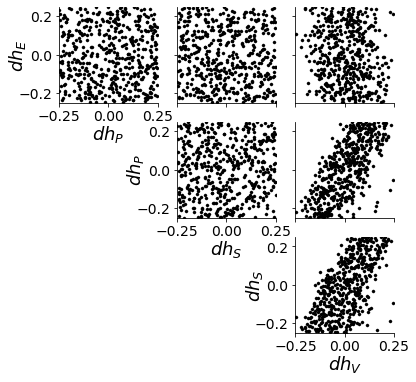

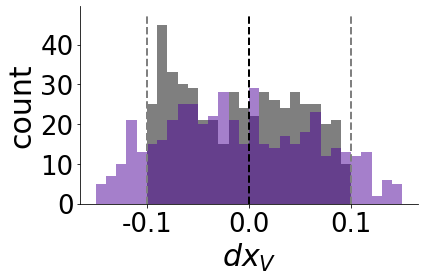

In [15]:
D = 4
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, alpha, inc_std):
    neuron_ind = neuron_inds[alpha]
    return np.logical_and(-2*inc_std < T_x[:,neuron_ind], 
                          T_x[:,neuron_ind] < 2*inc_std)

alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)
num_keep = 500
num_plot = 500
M = 1000
zs = []
T_xs = []

inc_std = 0.05
contrasts = [0., 1.]
eps = 0.01
sssn_sim = SSSN_sim(eps, N=1)

for i, contrast in enumerate(contrasts):
    H = HB + contrast*HC
    h = tf.constant(H[None,:], dtype=tf.float32)
    def dr(dh):
        x1 = tf.reduce_mean(sssn_sim(h + tf.zeros_like(dh, dtype=tf.float32))[:,:,:4], axis=1)
        x2 = tf.reduce_mean(sssn_sim(h + dh)[:,:,:4], axis=1)

        diff = x2 - x1
        T_x = tf.concat((diff, diff ** 2), axis=1)

        return T_x
    
    model.set_eps(dr)
    zs_j = []
    T_xs_j = []
    for j, alpha in enumerate(alphas):
        alpha = alphas[j]
        name = "ABC_SSSN_%s_c=%.1f_eps=%.3f" % (alpha, contrast, eps)
        neuron_ind = neuron_inds[alpha]
        fontsize = 30

        num_found = 0
        z = None
        T_x = None
        count = 0
        while (num_found < num_keep):
            count += 1
            _z = np.zeros((M, D))
            for d in range(D):
                _z[:,d] = np.random.uniform(lb[d], ub[d], (M,))
            _T_x = model.eps(_z).numpy()
            #print('min', np.min(_T_x[:0]))
            #print('max', np.max(_T_x[:,0]))

            inds = accept_inds(_T_x, alpha, inc_std)
            _z = _z[inds, :]
            _T_x = _T_x[inds, :]
            num_found += _z.shape[0]
            
            if (z is None):
                z = _z
                T_x = _T_x
            else:
                z = np.concatenate((z, _z), axis=0)
                T_x = np.concatenate((T_x, _T_x), axis=0)
            print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

        num_found = z.shape[0]
        
        # reduce to num_keep
        z = z[:num_keep]
        T_x = T_x[:num_keep]
        zs_j.append(z)
        T_xs_j.append(T_x)
        
        #isn_coeffs = ISN_coeff(z, H[None,:]).numpy()

        _dv = T_x[:,neuron_ind]
        z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
        fig = pairplot(z[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                       c=None,
                       #c=isn_coeffs,
                       fontsize=18, lb=lb, ub=ub, labelpads=(0,-10))
        plt.savefig(figdir + name + '_z.png')
        
        T_x_sim = model.eps(z).numpy()
        
        plot_T_x(T_x[:,neuron_ind], T_x_sim[:,neuron_ind], x_mean=0., x_std=inc_std, xmin=-3*inc_std, xmax=3.*inc_std, xlabel=r'$dx_%s$' % alpha, fontsize=30)
        plt.tight_layout()
        plt.savefig(figdir + name + '_Tx.png')
        
    
    zs.append(zs_j)
    T_xs.append(T_xs_j)